In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
print(tf.__version__)

2.15.0


In [3]:

from keras import regularizers
from keras import ImageDataGenerator

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip "drive/My Drive/data2.zip"

Streaming output truncated to the last 5000 lines.
  inflating: data2/train1/SeborrheicKeratosesandotherBenignTumors/sebaceous-hyperplasia-17.jpg  
  inflating: data2/train1/SeborrheicKeratosesandotherBenignTumors/sebaceous-hyperplasia-18.jpg  
  inflating: data2/train1/SeborrheicKeratosesandotherBenignTumors/sebaceous-hyperplasia-20.jpg  
  inflating: data2/train1/SeborrheicKeratosesandotherBenignTumors/sebaceous-hyperplasia-22.jpg  
  inflating: data2/train1/SeborrheicKeratosesandotherBenignTumors/sebaceous-hyperplasia-23.jpg  
  inflating: data2/train1/SeborrheicKeratosesandotherBenignTumors/sebaceous-hyperplasia-24.jpg  
  inflating: data2/train1/SeborrheicKeratosesandotherBenignTumors/sebaceous-hyperplasia-25.jpg  
  inflating: data2/train1/SeborrheicKeratosesandotherBenignTumors/sebaceous-hyperplasia-26.jpg  
  inflating: data2/train1/SeborrheicKeratosesandotherBenignTumors/sebaceous-hyperplasia-27.jpg  
  inflating: data2/train1/SeborrheicKeratosesandotherBenignTumors/sebaceous-

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

In [8]:
BATCH_SIZE = 64
IMAGE_SIZE = 224
NUMBER_OF_CLASSES = 7
BUFFER_SIZE = 1000
TRAIN_DIR = 'data2/train1/'
VALIDATION_DIR = 'data2/validation1/'

In [9]:

BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync

yes


In [10]:
def train_val_datasets():
    """Creates training and validation datasets

    Returns:
        (tf.data.Dataset, tf.data.Dataset): training and validation datasets
    """

    # Training dataset with augmentation and preprocessing
    train_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
        rescale=1.0/255.0,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Validation dataset with preprocessing only (no augmentation)
    val_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
        rescale=1.0/255.0
    )

    # Create the generators
    training_dataset = train_datagen.flow_from_directory(
        directory=TRAIN_DIR,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=7
    )

    validation_dataset = val_datagen.flow_from_directory(
        directory=VALIDATION_DIR,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=7
    )

    return training_dataset, validation_dataset


In [11]:
training_dataset, validation_dataset= train_val_datasets()
print(f"Images in training dataset have shape: {training_dataset.image_shape}")
print(f"Number of classes in training dataset: {training_dataset.num_classes}")
print(f"Number of samples in training dataset: {training_dataset.samples}")

print(f"Images in validation dataset have shape: {validation_dataset.image_shape}")
print(f"Number of classes in validation dataset: {validation_dataset.num_classes}")
print(f"Number of samples in validation dataset: {validation_dataset.samples}")

Found 7700 files belonging to 7 classes.
Found 2029 files belonging to 7 classes.
Images of train dataset have shape: (None, 224, 224, 3)
Labels of train dataset have shape: (None, 7)
Images of validation dataset have shape: (None, 224, 224, 3)
Labels of validation dataset have shape: (None, 7)


In [12]:
def split_validation_dataset(validation_dataset, test_split_ratio=0.2):
    """
    Split the validation dataset into separate test and validation datasets.

    Args:
        validation_dataset: The validation dataset generator.
        test_split_ratio: Ratio of test samples within the validation dataset.

    Returns:
        validation_data (tf.keras.preprocessing.image.DirectoryIterator),
        test_data (tf.keras.preprocessing.image.DirectoryIterator)
    """
    total_batches = len(validation_dataset)
    test_batches = int(test_split_ratio * total_batches)
    validation_batches = total_batches - test_batches

    # Convert generator output to a list for splitting
    val_data = list(validation_dataset)

    test_data = val_data[:test_batches]
    validation_data = val_data[test_batches:]

    return validation_data, test_data


# Usag
validation_dataset, test_dataset = split_validation_dataset(validation_dataset)

# Print the number of batches for validation and test
print(f"Number of validation batches: {len(validation_dataset)}")
print(f"Number of test batches: {len(test_dataset)}")


Number of validation batches: 4
Number of test batches: 0


In [13]:
from keras.applications import MobileNetV3Small

def create_pre_trained_model():
    """Creates the pretrained MobileNetV3-Small model.

    Returns:
        tf.keras.Model: Pre-trained MobileNetV3-Small model
    """
    # Load the MobileNetV3-Small model without the top layers (include_top=False)
    pre_trained_model = MobileNetV3Small(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

    for layer in pre_trained_model.layers:
        layer.trainable = False

    return pre_trained_model


In [14]:
with strategy.scope():
    pre_trained_model = create_pre_trained_model()

# Count the total number of parameters and how many are trainable
num_total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {num_total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

12683000/12683000 [==============================] - 0s 0us/step
There are 2,996,352 total parameters in this model.
There are 0 trainable parameters in this model.


In [ ]:

pre_trained_model.summary()

In [16]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_accuracy']>0.85:
            self.model.stop_training = True
            print("\nReached 85.0% accuracy so cancelling training!")

In [17]:
def output_of_last_layer(pre_trained_model):
    """Fetches the output of the last available layer of the pre-trained model"""

    # Get the last layer in the model
    last_layer = pre_trained_model.layers[-1]
    last_output = last_layer.output
    print('Last layer output shape: ', last_layer.output.shape)

    return last_output

In [18]:
with strategy.scope():
    last_output = output_of_last_layer(pre_trained_model)

Last layer output shape:  (None, 7, 7, 960)


In [19]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.src.engine.functional.Functional'>


In [33]:
def create_final_model(pre_trained_model):
    """Creates final model by adding layers on top of the pretrained model.

    """
    x = pre_trained_model.output
    # Dense layers with gradually reducing units
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)



    # Final output layer for classification
    x = tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax')(x)

    model = tf.keras.models.Model(pre_trained_model.input, x)
    model.summary()


# Check if the model summary shows usage of multiple GPUs
    return model

In [23]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
class_labels = []
for _, labels in training_dataset:
    class_labels.extend(tf.argmax(labels, axis=1).numpy())  # Convert one-hot to class indices

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights = dict(enumerate(class_weights))

In [24]:
def adjust_learning_rate(pre_trained_model, dataset):
    """Fit model using different learning rates and support multiple GPUs.

    Args:
        dataset (tf.data.Dataset): train dataset

    Returns:
        tf.keras.callbacks.History: callback history
    """

    # Use MirroredStrategy for multi-GPU training
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

    # Create the model inside the strategy scope
    with strategy.scope():
        model = create_final_model(pre_trained_model)

        # Learning rate scheduler
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10 ** (epoch /3))

        # Select your optimizer
        optimizer = tf.keras.optimizers.Adam()

        # Compile the model
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy']
        )

    # Train the model with the learning rate scheduler and multiple GPUs
    history = model.fit(dataset, epochs=15, callbacks=[lr_schedule])

    return history

In [25]:
# Run the training with dynamic LR
#lr_history = adjust_learning_rate(pre_trained_model, last_output, training_dataset)

In [26]:
#plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])

In [27]:
# GRADED FUNCTION: create_model
from numpy.random import seed
def create_model(pre_trained_model):
    """Creates and compiles the model

    Returns:
        tf.keras.Model: compiled model
    """
    with strategy.scope():
      from numpy.random import seed
      seed(2)
      tf.random.set_seed(2)

      for layer in model.layers[:-50]:
          layer.trainable = False
      model = create_final_model(pre_trained_model)

        #optimizer = tf.keras.optimizers.SGD(momentum=0.9)
      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

    # Compile the model passing in the appropriate loss
      model.compile(
          optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics='categorical_accuracy')



    ### END CODE HERE ###

    return model

In [34]:
model = create_model(pre_trained_model)
# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                                  

In [35]:
history = model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = 100,
    class_weight=class_weights,
)

Epoch 1/100
16/16 [==============================] - 72s 3s/step - loss: 12.5220 - categorical_accuracy: 0.1661 - val_loss: 11.9928 - val_categorical_accuracy: 0.1981
Epoch 2/100
16/16 [==============================] - 11s 669ms/step - loss: 12.1382 - categorical_accuracy: 0.1888 - val_loss: 11.6495 - val_categorical_accuracy: 0.2459
Epoch 3/100
16/16 [==============================] - 11s 672ms/step - loss: 11.8866 - categorical_accuracy: 0.2086 - val_loss: 11.3888 - val_categorical_accuracy: 0.2686
Epoch 4/100
16/16 [==============================] - 11s 679ms/step - loss: 11.6732 - categorical_accuracy: 0.2191 - val_loss: 11.1705 - val_categorical_accuracy: 0.2918
Epoch 5/100
16/16 [==============================] - 11s 681ms/step - loss: 11.4564 - categorical_accuracy: 0.2191 - val_loss: 10.9699 - val_categorical_accuracy: 0.3070
Epoch 6/100
16/16 [==============================] - 11s 713ms/step - loss: 11.2400 - categorical_accuracy: 0.2394 - val_loss: 10.7960 - val_categorical_

In [ ]:
# Unfreeze layers from mixed7 onward

#for layer in pre_trained_model.layers[-5:]:
    #layer.trainable = True
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7)

    # Compile the model passing in the appropriate loss
#model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Continue training for fine-tuning
#fine_tune_history = model.fit(
    #training_dataset,
    #validation_data = validation_dataset, epochs=20)  # Fine-tuning phase


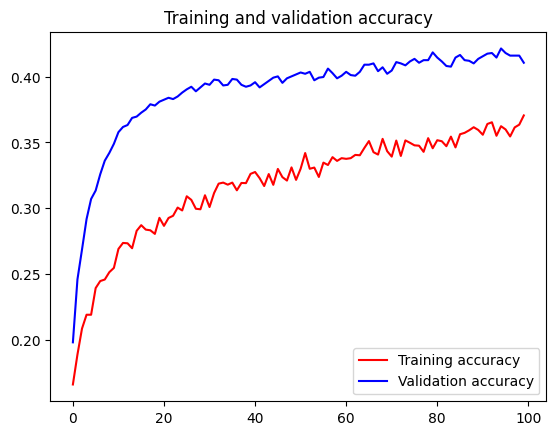

In [36]:
# Plot the training and validation accuracies for each epoch

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()


In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test loss: {test_loss},\nTest accuracy: {test_accuracy}')

In [ ]:
from tensorflow.python.saved_model.save import save
from google.colab import files

keras_path = '/content/modelV3(2.17).keras'
model.save(keras_path)

# Autodownload the .h5 model
files.download(keras_path)

In [37]:
from tensorflow.python.saved_model.save import save
from google.colab import files

h5_path = '/content/modelV4.h5'
model.save(h5_path)


# Autodownload the .h5 model
files.download(h5_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip3 install tensorflowjs

In [ ]:
!cd /content
tfjs_dir = '/content/modelkulit'
os.makedirs(tfjs_dir, exist_ok=True)
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model {save_dir} {tfjs_dir}

# Zip the TensorFlow.js files
zip_path = '/content/tfjs_modelkulit.zip'
!zip -r {zip_path} {tfjs_dir}

In [ ]:
from google.colab import files

# Autodownload the .h5 model
#files.download(h5_path)
zip_path_model = '/content/modelV3.zip'
!zip -r {zip_path_model} {save_dir}
# Autodownload the zipped TensorFlow.js model
files.download(zip_path_model)